# PREPROCESSING ROP IMAGE DATSET


In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Parameters
input_root = "ROP_data/ROPTEST3"
output_root = "Preprocessed_ROP_image"
target_size = (224, 224)  # CNN standard size (e.g., for ResNet, VGG)

# Ensure output folder exists
os.makedirs(output_root, exist_ok=True)

# Go through each class folder
class_folders = ['AROP1', 'AROP2', 'NORMALROP']

for class_name in class_folders:
    input_folder = os.path.join(input_root, class_name)
    output_folder = os.path.join(output_root, class_name)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Processing {class_name}...")

    for img_name in tqdm(os.listdir(input_folder)):
        img_path = os.path.join(input_folder, img_name)

        try:
            # Read image
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Convert to RGB if not already
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize to 224x224
            img = cv2.resize(img, target_size)

            # Normalize pixel values to [0, 1]
            img = img / 255.0

            # Optionally convert to float32 for deep learning compatibility
            img = img.astype(np.float32)

            # Save as .npy for fast loading in CNNs (preferred for training)
            out_path = os.path.join(output_folder, img_name.split('.')[0] + ".npy")
            np.save(out_path, img)

        except Exception as e:
            print(f"Failed to process {img_name}: {e}")


Processing AROP1...


100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


Processing AROP2...


100%|██████████| 849/849 [01:11<00:00, 11.85it/s]


Processing NORMALROP...


100%|██████████| 706/706 [00:45<00:00, 15.48it/s]


# IMPLEMENTING A MODEL

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F
from PIL import Image

# Dataset Loader for .npy images
class ROPDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.class_map = {'NORMALROP': 0, 'AROP1': 1, 'AROP2': 2}
        
        # Loop over all subfolders (AROP1, AROP2, NORMALROP)
        for class_name in self.class_map:
            class_dir = os.path.join(root_dir, class_name)
            for file in os.listdir(class_dir):
                if file.endswith('.npy'):
                    img = np.load(os.path.join(class_dir, file))
                    self.data.append(img)
                    self.labels.append(self.class_map[class_name])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        # Ensure the image is 2D (grayscale), then expand to 3 channels (RGB)
        if len(img.shape) == 2:  # If it's a grayscale image
            img = np.repeat(img[..., np.newaxis], 3, axis=2)  # Convert to 3 channels (RGB)
        
        if self.transform:
            img = self.transform(img)
        return img, label

# Define transformations (resize and convert to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize image to 224x224 (resnet input size)
])

# Path to preprocessed images
dataset_path = 'Preprocessed_ROP_image'

# Create dataset and DataLoader
dataset = ROPDataset(dataset_path, transform=transform)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# Model using Transfer Learning (ResNet18)
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 3)  # Output layer for 3 classes (NORMALROP, AROP1, AROP2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "rop_model.pth")


Epoch [1/10], Loss: 3.9263
Epoch [2/10], Loss: 0.1291
Epoch [3/10], Loss: 0.0674
Epoch [4/10], Loss: 0.0962
Epoch [5/10], Loss: 0.0779
Epoch [6/10], Loss: 0.0575
Epoch [7/10], Loss: 0.0188
Epoch [8/10], Loss: 0.0215
Epoch [9/10], Loss: 0.0113
Epoch [10/10], Loss: 0.0072


# USING REALTIME DATSET TO TEST THE MODEL

📌 Select input type:
1. Provide image from folder
2. Capture image from camera


Enter 1 or 2:  1
📂 Enter the full path of the image or .npy file:  777_20240123155618.png



🔍 Prediction: AROP1
🔐 Confidence: 0.8373
📊 Trust Score: ⚠️ Moderate Trust
🧠 Diagnosis: ✅ Retinopathy Detected

📊 Displaying brightness histogram...


C:\Users\abhis\AppData\Local\Temp\ipykernel_2084\1493432265.py:57: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  plt.tight_layout()


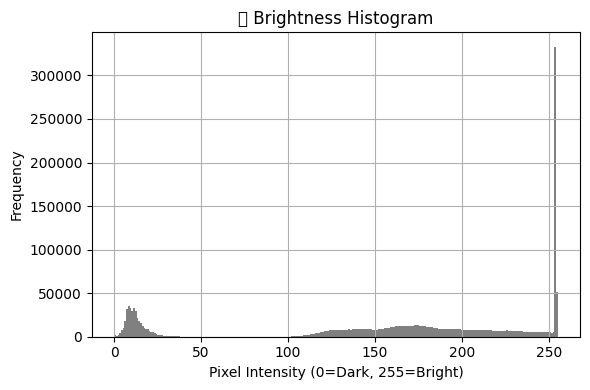

In [26]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import tempfile
import torch.nn.functional as F

# Class map
class_map = {0: 'NORMALROP', 1: 'AROP1', 2: 'AROP2'}
retinopathy_classes = ['AROP1', 'AROP2']

# Transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load("rop_model.pth", map_location=device))
model.to(device)
model.eval()

# Load image from path or npy
def load_image(file_path):
    ext = os.path.splitext(file_path)[1].lower()

    if ext == '.npy':
        img = np.load(file_path)
        if img.ndim == 2:
            img = np.repeat(img[..., np.newaxis], 3, axis=2)
        img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)
        original = Image.fromarray(img)
    else:
        original = Image.open(file_path).convert("RGB")

    img_tensor = transform(original).unsqueeze(0)
    return img_tensor, original

# Plot brightness histogram
def plot_brightness_histogram(image):
    gray = image.convert("L")
    pixel_values = np.array(gray).flatten()

    plt.figure(figsize=(6, 4))
    plt.hist(pixel_values, bins=256, range=(0, 255), color='gray')
    plt.title("🧪 Brightness Histogram")
    plt.xlabel("Pixel Intensity (0=Dark, 255=Bright)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Capture image from webcam
def capture_image_from_camera():
    cap = cv2.VideoCapture(0)
    print("📷 Press 'c' to capture the image, or 'q' to quit.")
    captured_path = None

    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Failed to open camera.")
            break

        cv2.imshow("Live Camera - Press 'c' to capture", frame)
        key = cv2.waitKey(1)

        if key & 0xFF == ord('c'):
            with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp:
                captured_path = tmp.name
                cv2.imwrite(captured_path, frame)
                print(f"✅ Image captured and saved at: {captured_path}")
            break
        elif key & 0xFF == ord('q'):
            print("🚪 Exiting without capturing.")
            break

    cap.release()
    cv2.destroyAllWindows()
    return captured_path

# Confidence Trust Report
def get_trust_score(probability):
    if probability >= 0.9:
        return "✅ High Trust"
    elif probability >= 0.7:
        return "⚠️ Moderate Trust"
    else:
        return "❌ Low Trust"

# Inference
def predict_image():
    print("📌 Select input type:\n1. Provide image from folder\n2. Capture image from camera")
    option = input("Enter 1 or 2: ").strip()

    if option == '1':
        file_path = input("📂 Enter the full path of the image or .npy file: ").strip()
    elif option == '2':
        file_path = capture_image_from_camera()
        if file_path is None:
            return
    else:
        print("❌ Invalid option.")
        return

    if not os.path.exists(file_path):
        print("❌ File not found.")
        return

    img_tensor, original_img = load_image(file_path)
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1).cpu().numpy()[0]
        pred_class = np.argmax(probabilities)
        pred_label = class_map[pred_class]
        confidence = probabilities[pred_class]

        print(f"\n🔍 Prediction: {pred_label}")
        print(f"🔐 Confidence: {confidence:.4f}")
        print(f"📊 Trust Score: {get_trust_score(confidence)}")

        if pred_label in retinopathy_classes:
            print("🧠 Diagnosis: ✅ Retinopathy Detected")
        else:
            print("🧠 Diagnosis: ❌ No Retinopathy (Normal)")

        # Histogram
        print("\n📊 Displaying brightness histogram...")
        plot_brightness_histogram(original_img)

# 🔁 Run prediction
predict_image()
